In [35]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input


In [36]:
import numpy as np
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [37]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("goubeast/age-prediction-av")
#print("Path to dataset files:", path)

In [100]:
#! ls data/train/old


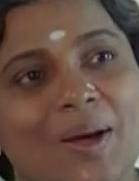

In [39]:
path = './data/train/old'
#name = '82.headshot.jpg'
name = '10019.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [40]:
img = load_img(fullname, target_size=(200, 200))
x = np.array(img)
x.shape

(200, 200, 3)

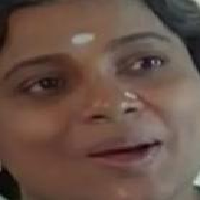

In [41]:
img

Model from scratch

In [42]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [43]:
model.compile(loss='binary_crossentropy',\
             optimizer=optimizers.SGD(learning_rate=0.002, momentum=0.8),\
             metrics=['acc'])

In [44]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 313632)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │    20,072,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,073,473 (76.57 MB)

 Trainable params: 20,073,473 (76.57 MB)

 Non-trainable params: 0 (0.00 B)

Transfer learning: Reusing Imagenet model

In [45]:
from keras.applications.xception import Xception

In [61]:
# modify create model function
def create_model(learning_rate=0.001, size_inner=100):
  base_model = Xception(
      weights='imagenet',
      include_top=False,
      input_shape=(200, 200, 3)
  )
  base_model.trainable = False

  inputs = keras.Input(
      shape=(200,200,3)
  )

  base = base_model(inputs, training=False)

  vectors = keras.layers.GlobalAveragePooling2D()(base)

  # adding inner layer
  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)

  # 2 classes
  outputs = keras.layers.Dense(2)(inner)

  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  loss = keras.losses.SparseCategoricalCrossentropy(
      from_logits=True
  )

  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy']
  )

  return model


In [62]:
train_dir = 'data/train'
test_dir = 'data/test'

#train_datagen = ImageDataGenerator(rescale=1./255)
#val_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [63]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 6830 images belonging to 2 classes.


In [64]:
train_generator.class_indices

{'old': 0, 'young': 1}

In [65]:
validation_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 2277 images belonging to 2 classes.


In [66]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 200, 200, 3)
labels batch shape: (20,)


In [75]:
# Create checkpoint
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'#max monitor variable
)

In [68]:
model = create_model()

In [69]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
)

Epoch 1/10


I0000 00:00:1737571847.975532    1486 service.cc:148] XLA service 0x7f41500024e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737571847.975565    1486 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-01-22 18:50:48.068781: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737571848.766157    1486 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-22 18:50:51.904549: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  3/342 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.6417 - loss: 0.6423

I0000 00:00:1737571852.768165    1486 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


342/342 ━━━━━━━━━━━━━━━━━━━━ 45s 107ms/step - accuracy: 0.8144 - loss: 0.4083 - val_accuracy: 0.8621 - val_loss: 0.3133
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.8739 - loss: 0.2949 - val_accuracy: 0.8748 - val_loss: 0.2979
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.8959 - loss: 0.2404 - val_accuracy: 0.8810 - val_loss: 0.2990
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9183 - loss: 0.1939 - val_accuracy: 0.8876 - val_loss: 0.2776
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9409 - loss: 0.1529 - val_accuracy: 0.8854 - val_loss: 0.2854
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9508 - loss: 0.1319 - val_accuracy: 0.8937 - val_loss: 0.2942
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9634 - loss: 0.0969 - val_accuracy: 0.8902 - val_loss: 0.2992
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9698 - loss: 0.0836 - val_accura

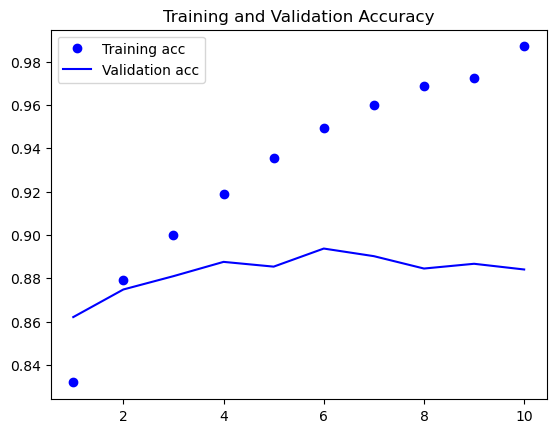

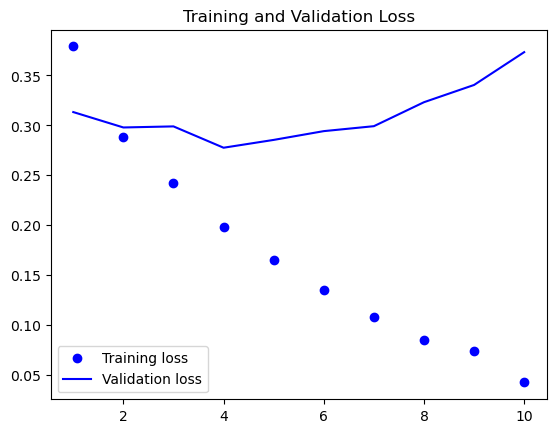

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [72]:
acc_median = np.median(acc)
acc_median

np.float64(0.9425329267978668)

In [73]:
loss_std = np.std(loss)
loss_std

np.float64(0.10077981570257692)

Data Augmentation

In [101]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [102]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [103]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 6830 images belonging to 2 classes.


In [104]:
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 2281 images belonging to 2 classes.


In [105]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7846 - loss: 0.7043

/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


342/342 ━━━━━━━━━━━━━━━━━━━━ 68s 187ms/step - accuracy: 0.7846 - loss: 0.7036 - val_accuracy: 0.8623 - val_loss: 0.3381
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 64s 188ms/step - accuracy: 0.8310 - loss: 0.3897 - val_accuracy: 0.8553 - val_loss: 0.3353
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 179ms/step - accuracy: 0.8312 - loss: 0.3674 - val_accuracy: 0.8755 - val_loss: 0.3208
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 179ms/step - accuracy: 0.8423 - loss: 0.3585 - val_accuracy: 0.8733 - val_loss: 0.3389
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 179ms/step - accuracy: 0.8500 - loss: 0.3397 - val_accuracy: 0.8724 - val_loss: 0.3123
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 179ms/step - accuracy: 0.8625 - loss: 0.3269 - val_accuracy: 0.8685 - val_loss: 0.3236
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 179ms/step - accuracy: 0.8531 - loss: 0.3346 - val_accuracy: 0.8772 - val_loss: 0.3267
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 179ms/step - accuracy: 0.8619 - loss: 0.3154 - val

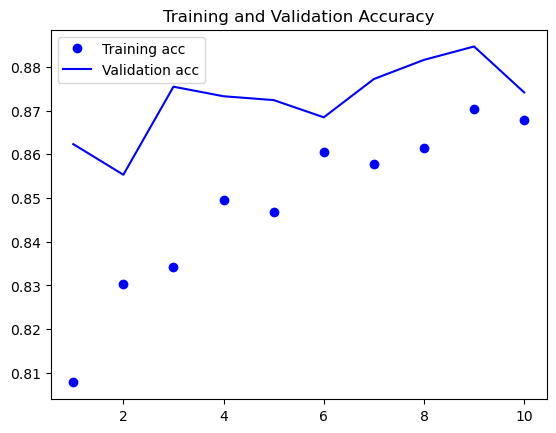

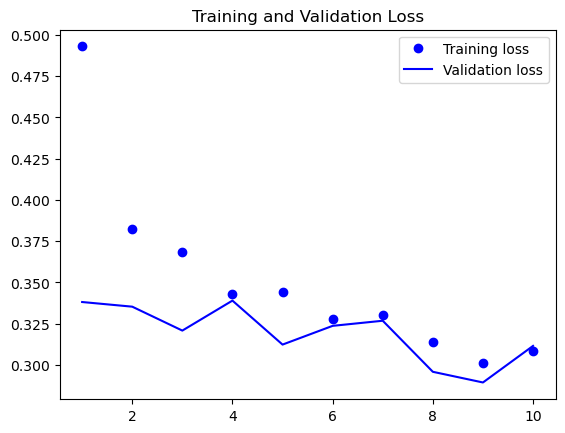

In [106]:
acc_aug = history.history['accuracy']
val_acc_aug = history.history['val_accuracy']
loss_aug = history.history['loss']
val_loss_aug = history.history['val_loss']

epochs_aug = range(1, len(acc) + 1)

plt.plot(epochs_aug, acc_aug, 'bo', label='Training acc')
plt.plot(epochs_aug, val_acc_aug, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_aug, loss_aug, 'bo', label='Training loss')
plt.plot(epochs_aug, val_loss_aug, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [107]:
loss_mean_aug = np.mean(val_loss_aug)
loss_mean_aug

np.float64(0.3192213803529739)

In [108]:
val_acc_aug[5:10]

[0.8684787154197693,
 0.8772467970848083,
 0.8816308379173279,
 0.8846997022628784,
 0.8741779923439026]

In [109]:
acc_mean_aug = np.mean(val_acc_aug[5:10])
acc_mean_aug

np.float64(0.8772468090057373)

Using a saved model via checkpoint

In [110]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

In [111]:
model = keras.models.load_model('xception_v1_08_0.893.keras')

In [112]:
model.evaluate(validation_generator)

115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.8829 - loss: 0.5306


[0.503397524356842, 0.8925909399986267]

In [113]:
path = 'data/test/young/10056.jpg'
img = load_img(path, target_size=(200, 200))

In [114]:
import numpy as np
x = np.array(img)
X = np.array([x])
X.shape

(1, 200, 200, 3)

In [115]:
X = preprocess_input(X)
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [116]:
pred[0]

array([-1.584364 ,  1.1029187], dtype=float32)

In [117]:
import tensorflow as tf

probabilities = tf.nn.softmax(pred[0]).numpy()
print(probabilities)

[0.06372795 0.936272  ]


Convert model to TF-Lite

In [118]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('model.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpw9y48cf_/assets


INFO:tensorflow:Assets written to: /tmp/tmpw9y48cf_/assets


Saved artifact at '/tmp/tmpw9y48cf_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name='input_layer_10')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  139918695635600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139918695637136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139918695637328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139918695636944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139918695634064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139918695637712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139918695639056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139918695639248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139918695638864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139918695638096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139918695639

W0000 00:00:1737575718.031029     328 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1737575718.031057     328 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-22 19:55:18.031496: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpw9y48cf_
2025-01-22 19:55:18.042015: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-22 19:55:18.042044: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpw9y48cf_
I0000 00:00:1737575718.161413     328 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-01-22 19:55:18.181410: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-22 19:55:19.069361: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpw9y48cf_
2025-01-22 19:55:19.259154: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 